# Analysis of `wandb` Logs and Metrics
This notebook collects different metrics for a specified experiment.

# Setup

In [1]:
import numpy as np
import pprint
from typing import Literal, List
from json import loads, dumps

import warnings

warnings.filterwarnings("ignore")

import wandb

api = wandb.Api()

import pandas as pd

In [2]:
runs = api.runs("uedyiuajxz-personal/qfl-prod-le-2")

In [3]:
groups = list(set(run.config.get("group", None) for run in runs))
print(groups)

['FHE-fedqnn-14378197', 'Standard-resnet18-qcnn-14166524', 'Standard-resnet18-qnn-14288059', 'FHE-resnet18-14096299', 'Standard-resnet18-qnn-14378202', 'Standard-resnet18-qcnn-14378204', 'FHE-fednn-14378195', 'FHE-resnet18-14288058', 'FHE-resnet18-qnn-14385582', 'FHE-resnet18-qcnn-14616215', 'Standard-resnet18-14385579', 'Standard-resnet18-qnn-14385581', 'FHE-resnet18-14385580', 'FHE-resnet18-qcnn-14621587', 'Standard-fednn-14378194', 'FHE-qcnn-14378199', 'FHE-fednn-14288052', 'Standard-resnet18-qcnn-14385583', 'FHE-resnet18-qcnn-14568056', 'Standard-resnet18-14096298', 'FHE-resnet18-14378201', 'FHE-resnet18-qnn-14096301', 'FHE-fedqnn-14096295', 'Standard-qcnn-14288055', 'FHE-resnet18-qcnn-14629774', 'FHE-resnet18-qnn-14288060', 'Standard-resnet18-qcnn-14096302', 'Standard-resnet18-qnn-14166522', 'FHE-resnet18-qcnn-14602070', 'FHE-fednn-14166515', 'FHE-fedqnn-14288054', 'Standard-resnet18-14378200', 'FHE-resnet18-qnn-14166523', 'Standard-resnet18-qnn-14096300', 'FHE-qcnn-14096297', 'FH

# EDA

In [4]:
group_in_focus = groups[0]

In [5]:
grouped_runs = [run for run in runs if run.config.get("group", None) == group_in_focus]
server = None
clients = []

for run in grouped_runs:
    participant = run.config.get("participant", None)
    if participant == "server":
        server = run
    else:
        clients.append(run)
    print(f"Run ID: {run.id}, Name: {run.name}, Type: {participant}")

Run ID: rkqxsnlw, Name: server, Type: server
Run ID: 1bhibjf7, Name: client11, Type: client11
Run ID: 44lol4kj, Name: client17, Type: client17
Run ID: 5q9gkn7g, Name: client5, Type: client5
Run ID: 6tboidg9, Name: client10, Type: client10
Run ID: 9kwapfh6, Name: client1, Type: client1
Run ID: fjjuf3tl, Name: client16, Type: client16
Run ID: g2dko0ll, Name: client12, Type: client12
Run ID: gfl3ijmx, Name: client18, Type: client18
Run ID: gwm9j4no, Name: client7, Type: client7
Run ID: j03wlawl, Name: client19, Type: client19
Run ID: kuzd7xd4, Name: client8, Type: client8
Run ID: o7qg0nb8, Name: client4, Type: client4
Run ID: pj59dozb, Name: client6, Type: client6
Run ID: rl9yhinh, Name: client0, Type: client0
Run ID: rvv4lh8n, Name: client2, Type: client2
Run ID: vn2winms, Name: client9, Type: client9
Run ID: x8zkmc3r, Name: client15, Type: client15
Run ID: xpogalal, Name: client14, Type: client14
Run ID: xzzyeomi, Name: client13, Type: client13
Run ID: y71nvl8i, Name: client3, Type: cli

## Settings

In [6]:
pp = pprint.PrettyPrinter(indent=1, width=40)
pp.pprint(server.config)

{'batch_size': 32,
 'dataset': 'MRI',
 'fhe_enabled': True,
 'group': 'FHE-fedqnn-14378197',
 'learning_rate': '1e-3',
 'model': 'fedqnn',
 'number_clients': 20,
 'participant': 'server',
 'rounds': 20}


## Server and Aggregated Metrics

In [7]:
def compute_statistics(arr: np.ndarray) -> dict:
    """
    Compute basic statistical measures of an array, including mean, median, standard deviation,
    25th percentile (Q1), and 75th percentile (Q3).

    Parameters
    ----------
    arr : np.ndarray
        Input numerical array.

    Returns
    -------
    dict
        A dictionary containing the following statistics:
        - "mean" : float
            The average of the array.
        - "median" : float
            The middle value of the array.
        - "std" : float
            The standard deviation (sample standard deviation with `ddof=1`).
        - "25%" : float
            The 25th percentile (Q1).
        - "75%" : float
            The 75th percentile (Q3).

    Examples
    --------
    >>> import numpy as np
    >>> data = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
    >>> compute_statistics(data)
    {'mean': 55.0, 'median': 55.0, 'std': 30.276503540974915, '25%': 32.5, '75%': 77.5}
    """
    if not isinstance(arr, np.ndarray):
        arr = np.array(arr)

    stats = {
        "mean": np.mean(arr),
        "median": np.median(arr),
        "std": np.std(arr, ddof=1),
        "25%": np.percentile(arr, 25),
        "75%": np.percentile(arr, 75),
        "min": np.min(arr),
        "max": np.max(arr),
        "last_value": arr[-1],
    }
    return stats

In [8]:
from rich.console import Console
from rich.table import Table

console = Console()

# Create Table 1 (Basic Stats: Mean, Median, Std)
table1 = Table(title="Server Statistics (Part 1)")
table1.add_column("Metric", justify="left", style="cyan", min_width=20)
table1.add_column("Mean", justify="right", style="green", min_width=12)
table1.add_column("Median", justify="right", style="green", min_width=12)
table1.add_column("Std", justify="right", style="green", min_width=12)

# Create Table 2 (Percentiles + Min/Max/Last Value)
table2 = Table(title="Server Statistics (Part 2)")
table2.add_column("Metric", justify="left", style="cyan", min_width=20)
table2.add_column("25%", justify="right", style="green", min_width=12)
table2.add_column("75%", justify="right", style="green", min_width=12)
table2.add_column("Max", justify="right", style="green", min_width=12)
table2.add_column("Min", justify="right", style="green", min_width=12)
table2.add_column("Last", justify="right", style="green", min_width=12)

server_history = server.history()
for metric in server_history.keys():
    metric_values = [val for val in server_history[metric] if not np.isnan(val)]
    stats = compute_statistics(metric_values)

    # Add row to Table 1
    table1.add_row(
        metric, f"{stats['mean']:.2f}", f"{stats['median']:.2f}", f"{stats['std']:.2f}"
    )

    # Add row to Table 2
    table2.add_row(
        metric,
        f"{stats['25%']:.2f}",
        f"{stats['75%']:.2f}",
        f"{stats['max']:.2f}",
        f"{stats['min']:.2f}",
        f"{stats['last_value']:.2f}",
    )


console.print(table1)
console.print(table2)

                            Server Statistics (Part 1)                             
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓
┃ Metric                     ┃            Mean ┃          Median ┃            Std ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━┩
│ Bytes Sent (Round)         │    263248506.95 │    277103165.00 │    61959914.41 │
│ Total Bytes Received       │ 148258638025.70 │ 148258629363.50 │ 83534255800.23 │
│ metrics_agg.recalls        │            0.62 │            0.67 │           0.12 │
│ metrics_agg.f1s            │            0.62 │            0.67 │           0.12 │
│ _timestamp                 │   1748197635.85 │   1748197694.14 │        6311.87 │
│ parameter_aggregation_time │           63.48 │           63.61 │           2.83 │
│ _step                      │           10.50 │           10.50 │           6.49 │
│ metrics_agg.precisions     │            0.62 │            0.67 │           0.12 │
│ trainable_parameters       │         2112.00 │         2112.00 │            nan │
│ metrics_agg.accuracy       │           62.22 │           66.78 │          11.84 │
│ _runtime                   │        10355.87 │        10414.15 │        6311.88 │
│ Total Bytes Sent           │   2632490071.50 │   2632490071.50 │  1639364432.29 │
│ Bytes Received (Round)     │  14119866150.15 │  14119861588.50 │       31847.95 │
│ total_training_time        │        19670.36 │        19670.36 │            nan │
│ round                      │           10.50 │           10.50 │           5.92 │
│ loss_agg                   │            0.91 │            0.86 │           0.19 │
│ round_time                 │          898.60 │          902.26 │          13.33 │
└────────────────────────────┴─────────────────┴─────────────────┴────────────────┘

                                            Server Statistics (Part 2)                                             
┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Metric                  ┃            25% ┃             75% ┃             Max ┃            Min ┃            Last ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Bytes Sent (Round)      │   277103165.00 │    277103165.00 │    277103165.00 │       10004.00 │    277103165.00 │
│ Total Bytes Received    │ 81189241280.00 │ 215328018860.25 │ 282397323003.00 │ 14119912164.00 │ 282397323003.00 │
│ metrics_agg.recalls     │           0.59 │            0.71 │            0.74 │           0.34 │            0.74 │
│ metrics_agg.f1s         │           0.59 │            0.71 │            0.74 │           0.34 │            0.74 │
│ _timestamp              │  1748192523.11 │   1748202870.23 │   1748206952.94 │  1748187282.55 │   1748206952.94 │
│ parameter_aggregation_… │          61.30 │           64.02 │           69.71 │          57.71 │           60.06 │
│ _step                   │           5.25 │           15.75 │           21.00 │           0.00 │           21.00 │
│ metrics_agg.precisions  │           0.59 │            0.71 │            0.74 │           0.34 │            0.74 │
│ trainable_parameters    │        2112.00 │         2112.00 │         2112.00 │        2112.00 │         2112.00 │
│ metrics_agg.accuracy    │          58.77 │           70.56 │           73.81 │          33.68 │           73.81 │
│ _runtime                │        5243.12 │        15590.24 │        19673.04 │           2.59 │        19673.04 │
│ Total Bytes Sent        │  1316250037.75 │   3948730105.25 │   5264970139.00 │       10004.00 │   5264970139.00 │
│ Bytes Received (Round)  │ 14119845378.25 │  14119896393.00 │  14119912164.00 │ 14119793896.00 │  14119793896.00 │
│ total_training_time     │       19670.36 │        19670.36 │        19670.36 │       19670.36 │        19670.36 │
│ round                   │           5.75 │           15.25 │           20.00 │           1.00 │           20.00 │
│ loss_agg                │           0.76 │            1.01 │            1.38 │           0.71 │            0.71 │
│ round_time              │         900.85 │          903.17 │          911.08 │         851.31 │          851.31 │
└─────────────────────────┴────────────────┴─────────────────┴─────────────────┴────────────────┴─────────────────┘

## Client Metrics

In [9]:
def compute_client_statistics(client_histories):
    """
    Computes statistics for each metric by merging values across all clients.

    Parameters
    ----------
    client_histories : list[dict]
        A list of dictionaries where each dictionary contains metric history for a single client.

    Returns
    -------
    dict
        A dictionary where each key is a metric name and the value is its computed statistics.
    """
    merged_metrics = {}

    # Iterate through all client histories
    for client_history in client_histories:
        for metric, values in client_history.items():
            # Remove NaN values and flatten lists
            cleaned_values = [val for val in values if not np.isnan(val)]

            # Merge values from all clients
            if metric not in merged_metrics:
                merged_metrics[metric] = []
            merged_metrics[metric].extend(cleaned_values)

    # Compute statistics for each metric
    stats_dict = {
        metric: compute_statistics(np.array(values))
        for metric, values in merged_metrics.items()
    }

    return stats_dict


# Example: Fetch history from multiple clients
client_histories = [
    client.history() for client in clients
]  # Replace with actual client list

# Compute merged statistics
merged_stats = compute_client_statistics(client_histories)

# Display results using rich
console = Console()

# Create Table 1 (Basic Stats: Mean, Median, Std)
table1 = Table(title="Merged Client Metrics Statistics (Part 1)")
table1.add_column("Metric", justify="left", style="cyan", min_width=20)
table1.add_column("Mean", justify="right", style="green", min_width=12)
table1.add_column("Median", justify="right", style="green", min_width=12)
table1.add_column("Std", justify="right", style="green", min_width=12)

# Create Table 2 (Percentiles + Min/Max/Last Value)
table2 = Table(title="Merged Client Metrics Statistics (Part 2)")
table2.add_column("Metric", justify="left", style="cyan", min_width=20)
table2.add_column("25%", justify="right", style="green", min_width=12)
table2.add_column("75%", justify="right", style="green", min_width=12)
table2.add_column("Max", justify="right", style="green", min_width=12)
table2.add_column("Min", justify="right", style="green", min_width=12)
table2.add_column("Last", justify="right", style="green", min_width=12)

# Populate table with computed statistics
for metric, stats in merged_stats.items():
    table1.add_row(
        metric, f"{stats['mean']:.2f}", f"{stats['median']:.2f}", f"{stats['std']:.2f}"
    )

    # Add row to Table 2
    table2.add_row(
        metric,
        f"{stats['25%']:.2f}",
        f"{stats['75%']:.2f}",
        f"{stats['max']:.2f}",
        f"{stats['min']:.2f}",
        f"{stats['last_value']:.2f}",
    )

# Display table
console.print(table1)
console.print(table2)

                 Merged Client Metrics Statistics (Part 1)                 
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Metric                   ┃          Mean ┃        Median ┃          Std ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ _step                    │      11847.02 │       2992.00 │     14407.55 │
│ _runtime                 │       4882.63 │         38.87 │      6632.24 │
│ _timestamp               │ 1748203581.48 │ 1748208924.37 │      7102.89 │
│ decryption_time          │          1.53 │          1.61 │         0.36 │
│ encryption_time          │          1.93 │          1.57 │         1.16 │
│ client_round_time        │        850.51 │        856.99 │        30.45 │
│ client_cpu_percentage    │        188.15 │        157.80 │       165.38 │
│ client_real_memory_mb    │       3676.92 │       3761.40 │       732.36 │
│ server_virtual_memory_mb │      65189.75 │      66973.24 │     13320.43 │
│ server_cpu_percentage    │         22.85 │          0.00 │       132.68 │
│ client_virtual_memory_mb │      15796.16 │      16054.89 │      1469.10 │
│ server_real_memory_mb    │      51372.98 │      53004.81 │     12413.83 │
└──────────────────────────┴───────────────┴───────────────┴──────────────┘

                                 Merged Client Metrics Statistics (Part 2)                                  
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Metric                   ┃           25% ┃           75% ┃           Max ┃           Min ┃          Last ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ _step                    │         11.00 │      24514.75 │      42451.00 │          0.00 │      42451.00 │
│ _runtime                 │         20.47 │       9739.16 │      19612.77 │          1.27 │         40.43 │
│ _timestamp               │ 1748198190.96 │ 1748208945.19 │ 1748208960.91 │ 1748187344.19 │ 1748208960.91 │
│ decryption_time          │          1.50 │          1.68 │          1.90 │          0.02 │          1.41 │
│ encryption_time          │          1.23 │          2.29 │          9.91 │          0.79 │          2.22 │
│ client_round_time        │        829.49 │        877.34 │        898.40 │        743.97 │        812.19 │
│ client_cpu_percentage    │         73.90 │        283.20 │       1054.10 │          0.00 │          0.00 │
│ client_real_memory_mb    │       3679.31 │       3815.51 │       5681.81 │        924.23 │       3004.77 │
│ server_virtual_memory_mb │      66884.17 │      67359.26 │      79974.59 │       7416.56 │      54477.05 │
│ server_cpu_percentage    │          0.00 │          0.00 │       1510.40 │          0.00 │          0.00 │
│ client_virtual_memory_mb │      15965.41 │      16128.04 │      17971.63 │       9438.59 │      15360.23 │
│ server_real_memory_mb    │      52919.16 │      53370.86 │      65908.17 │        884.39 │      40540.01 │
└──────────────────────────┴───────────────┴───────────────┴───────────────┴───────────────┴───────────────┘

## Other Computations

In [10]:
some_client = clients[0]
history = some_client.history()
metric_values = [val for val in history["client_round_time"] if not np.isnan(val)]
sum(metric_values)

16943.033947467804

# Visuals and Stats for Thesis
## Globals

In [11]:
COLOR = "#A9A9A9"
KEY_ORDER = [
    "Standard-fednn",
    "FHE-fednn",
    "Standard-fedqnn",
    "FHE-fedqnn",
    "Standard-qcnn",
    "FHE-qcnn",
    "Standard-resnet18",
    "FHE-resnet18",
    "Standard-resnet18-qnn",
    "FHE-resnet18-qnn",
    "Standard-resnet18-qcnn",
    "FHE-resnet18-qcnn",
]

## Training and Round Times
### Training Times

In [12]:
def get_dataframe_from_metrics_data(metrics: dict, metric_label: str) -> pd.DataFrame:
    data = []
    for client, samples in metrics.items():
        for sample in samples:
            data.append({"Model": client, metric_label: sample})
    return pd.DataFrame(data)


def get_metric_by_model_type(
    runs: List[wandb.apis.public.runs.Run],
    groups: List[str],
    metric_type: Literal["server_metric", "client_metric", "system_metric"],
    metric: str,
) -> dict:
    metrics = {}
    for group in groups:
        try:
            if (metric in ["encryption_time", "decryption_time"]) and (
                "FHE" not in group
            ):
                continue
            grouped_runs = [
                run for run in runs if run.config.get("group", None) == group
            ]
            history = None
            for run in grouped_runs:
                if metric_type == "system_metric" and run.name == "system_logs":
                    history = run.history()
                elif (
                    metric_type == "server_metric"
                    and run.config.get("participant", "") == "server"
                ):
                    history = run.history()
                elif metric_type == "client_metric" and "client" in run.config.get(
                    "participant", ""
                ):
                    history = run.history()
                else:
                    continue

                metric_values = [val for val in history[metric] if not np.isnan(val)]

                model = "-".join(group.split("-")[:-1])
                if model in metrics.keys():
                    metrics[model] = metrics[model] + metric_values
                else:
                    metrics[model] = metric_values
        except KeyError:
            print(f"Somehow parameter was not found for group {group}.")
            continue

    metrics = {k: metrics[k] for k in KEY_ORDER if k in metrics.keys()}
    return metrics

In [13]:
training_times = get_metric_by_model_type(
    runs, groups, "server_metric", "total_training_time"
)

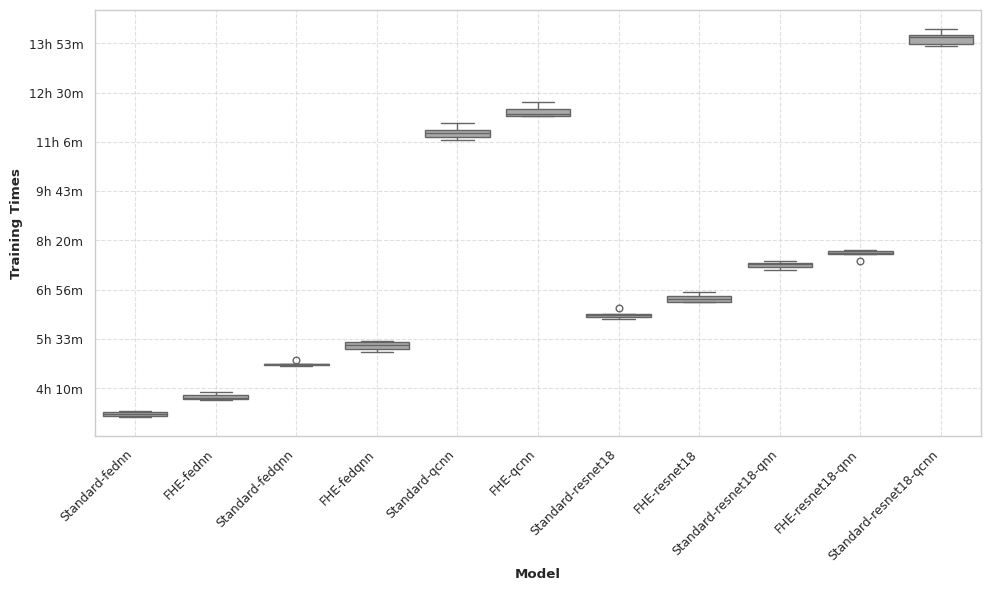

{
    "6": {
        "('Model', '')": "Standard-fednn",
        "('Training Times', 'count')": 0.0833333333,
        "('Training Times', 'mean')": 206.3974139643,
        "('Training Times', 'std')": 4.1982447968,
        "('Training Times', 'min')": 201.791916724,
        "('Training Times', '25%')": 202.8619424542,
        "('Training Times', '50%')": 206.0593141039,
        "('Training Times', '75%')": 210.0331022223,
        "('Training Times', 'max')": 211.2407943169
    },
    "0": {
        "('Model', '')": "FHE-fednn",
        "('Training Times', 'count')": 0.0833333333,
        "('Training Times', 'mean')": 235.9246222385,
        "('Training Times', 'std')": 5.4736597885,
        "('Training Times', 'min')": 230.6533737103,
        "('Training Times', '25%')": 232.0204767028,
        "('Training Times', '50%')": 234.1806450446,
        "('Training Times', '75%')": 238.7237062693,
        "('Training Times', 'max')": 244.0449094653
    },
    "7": {
        "('Model', '')": "S

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter


def format_time(seconds, _):
    if seconds < 60:
        return f"{int(seconds)}s"
    elif seconds < 3600:
        minutes = seconds // 60
        seconds = seconds % 60
        return f"{int(minutes)}m {int(seconds)}s"
    else:
        hours = seconds // 3600
        minutes = (seconds % 3600) // 60
        return f"{int(hours)}h {int(minutes)}m"


def display_boxplot(
    metrics_df: pd.DataFrame, metric_label: str, formatter: FuncFormatter = None
):
    sns.set_theme(style="whitegrid", context="paper")

    fig, ax = plt.subplots(figsize=(10, 6))
    sns.boxplot(x="Model", y=metric_label, data=metrics_df, color=COLOR)

    plt.xticks(rotation=45, ha="right")
    plt.xlabel("Model", fontweight="bold")
    plt.ylabel(metric_label, fontweight="bold")
    plt.grid(True, linestyle="--", alpha=0.6)

    if formatter:
        ax.yaxis.set_major_formatter(FuncFormatter(formatter))
    # Display the plot
    plt.tight_layout()
    plt.show()


metric_label = "Training Times"
df = get_dataframe_from_metrics_data(training_times, metric_label)
display_boxplot(df[df["Model"] != "FHE-resnet18-qcnn"], metric_label, format_time)
stats = (
    (df.groupby("Model").describe() / 60)
    .reset_index()
    .sort_values((metric_label, "mean"))
)

stats = stats.to_json(orient="index")
parsed = loads(stats)
print(dumps(parsed, indent=4))

### Client Round Times

In [15]:
client_round_times = get_metric_by_model_type(
    runs, groups, "client_metric", "client_round_time"
)

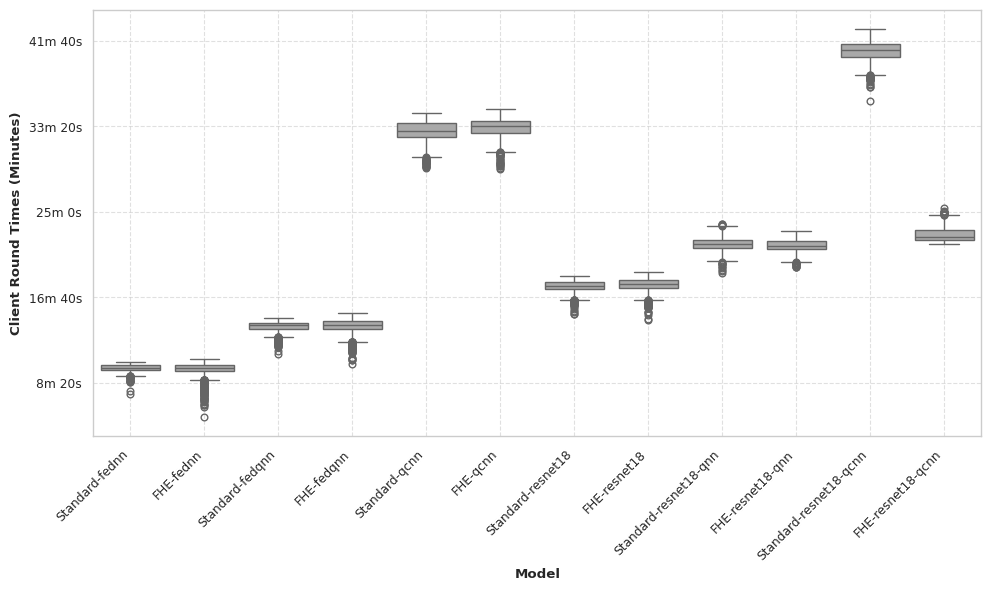

{
    "0": {
        "('Model', '')": "FHE-fednn",
        "('Client Round Times (Minutes)', 'count')": 33.3333333333,
        "('Client Round Times (Minutes)', 'mean')": 9.6877705368,
        "('Client Round Times (Minutes)', 'std')": 0.6256600128,
        "('Client Round Times (Minutes)', 'min')": 5.0383253098,
        "('Client Round Times (Minutes)', '25%')": 9.4868919492,
        "('Client Round Times (Minutes)', '50%')": 9.7998285015,
        "('Client Round Times (Minutes)', '75%')": 10.0400071462,
        "('Client Round Times (Minutes)', 'max')": 10.6619777958
    },
    "6": {
        "('Model', '')": "Standard-fednn",
        "('Client Round Times (Minutes)', 'count')": 33.3333333333,
        "('Client Round Times (Minutes)', 'mean')": 9.8181927068,
        "('Client Round Times (Minutes)', 'std')": 0.3006958271,
        "('Client Round Times (Minutes)', 'min')": 7.2207457622,
        "('Client Round Times (Minutes)', '25%')": 9.6441949497,
        "('Client Round Times (Min

In [16]:
metric_label = "Client Round Times (Minutes)"
df = get_dataframe_from_metrics_data(client_round_times, metric_label)
display_boxplot(df, metric_label, format_time)
stats = (
    (df.groupby("Model").describe() / 60)
    .reset_index()
    .sort_values((metric_label, "mean"))
)
stats = stats.to_json(orient="index")
parsed = loads(stats)
print(dumps(parsed, indent=4))

### Server Round Times

In [17]:
round_times = get_metric_by_model_type(runs, groups, "server_metric", "round_time")

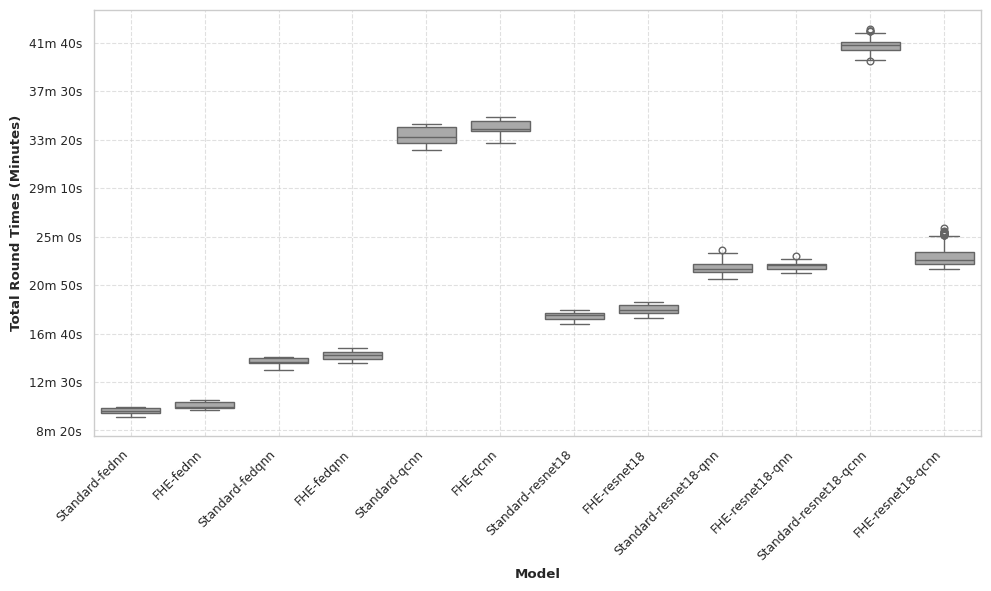

{
    "6": {
        "('Model', '')": "Standard-fednn",
        "('Total Round Times (Minutes)', 'count')": 1.6666666667,
        "('Total Round Times (Minutes)', 'mean')": 10.0427934759,
        "('Total Round Times (Minutes)', 'std')": 0.2276208912,
        "('Total Round Times (Minutes)', 'min')": 9.5075271726,
        "('Total Round Times (Minutes)', '25%')": 9.8048080951,
        "('Total Round Times (Minutes)', '50%')": 10.0176887055,
        "('Total Round Times (Minutes)', '75%')": 10.2488149931,
        "('Total Round Times (Minutes)', 'max')": 10.3579532226
    },
    "0": {
        "('Model', '')": "FHE-fednn",
        "('Total Round Times (Minutes)', 'count')": 1.6666666667,
        "('Total Round Times (Minutes)', 'mean')": 10.4641240091,
        "('Total Round Times (Minutes)', 'std')": 0.2507678464,
        "('Total Round Times (Minutes)', 'min')": 10.1223571777,
        "('Total Round Times (Minutes)', '25%')": 10.2808170348,
        "('Total Round Times (Minutes)', '50

In [18]:
metric_label = "Total Round Times (Minutes)"
df = get_dataframe_from_metrics_data(round_times, metric_label)
display_boxplot(df, metric_label, format_time)
stats = (
    (df.groupby("Model").describe() / 60)
    .reset_index()
    .sort_values((metric_label, "mean"))
)
stats = stats.to_json(orient="index")
parsed = loads(stats)
print(dumps(parsed, indent=4))

## CPU Usage

In [19]:
client_cpu_usage = get_metric_by_model_type(
    runs, groups, "system_metric", "client_cpu_percentage"
)

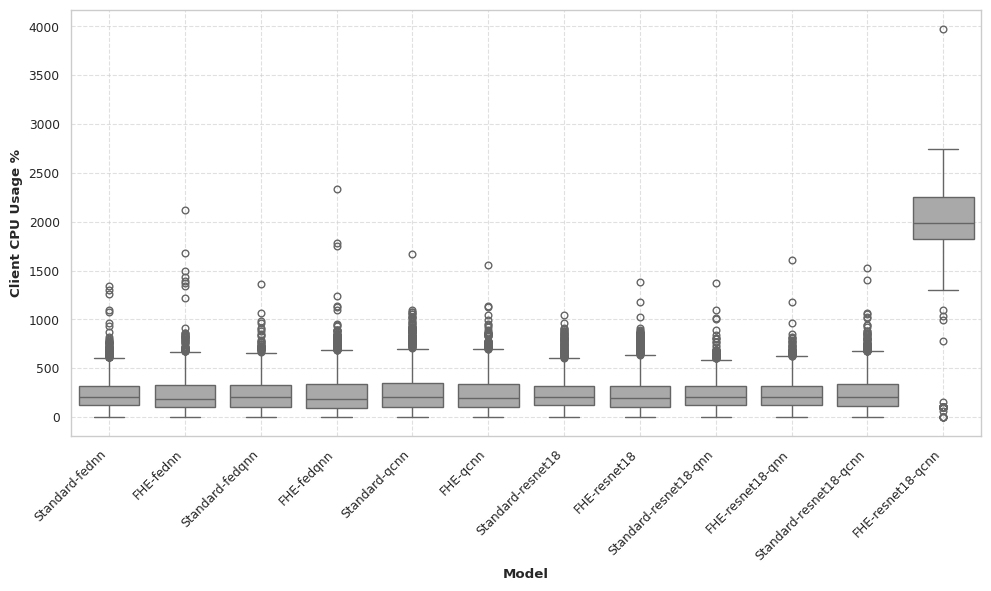

{
    "FHE-fednn": {
        "('Client CPU Usage %', 'count')": 2127.0,
        "('Client CPU Usage %', 'mean')": 230.9437705689,
        "('Client CPU Usage %', 'std')": 186.3320231669,
        "('Client CPU Usage %', 'min')": 2.0,
        "('Client CPU Usage %', '25%')": 97.9,
        "('Client CPU Usage %', '50%')": 185.8,
        "('Client CPU Usage %', '75%')": 327.3,
        "('Client CPU Usage %', 'max')": 2122.7
    },
    "FHE-fedqnn": {
        "('Client CPU Usage %', 'count')": 2205.0,
        "('Client CPU Usage %', 'mean')": 235.9660770975,
        "('Client CPU Usage %', 'std')": 199.5086758146,
        "('Client CPU Usage %', 'min')": 2.0,
        "('Client CPU Usage %', '25%')": 95.9,
        "('Client CPU Usage %', '50%')": 183.8,
        "('Client CPU Usage %', '75%')": 332.9,
        "('Client CPU Usage %', 'max')": 2339.3
    },
    "FHE-qcnn": {
        "('Client CPU Usage %', 'count')": 2399.0,
        "('Client CPU Usage %', 'mean')": 241.1052521884,
        "('C

In [20]:
metric_label = "Client CPU Usage %"
df = get_dataframe_from_metrics_data(client_cpu_usage, metric_label)
df = df[df[metric_label] > 0]
display_boxplot(df, metric_label)

stats = df.groupby("Model").describe()
stats = stats.to_json(orient="index")
parsed = loads(stats)
print(dumps(parsed, indent=4))

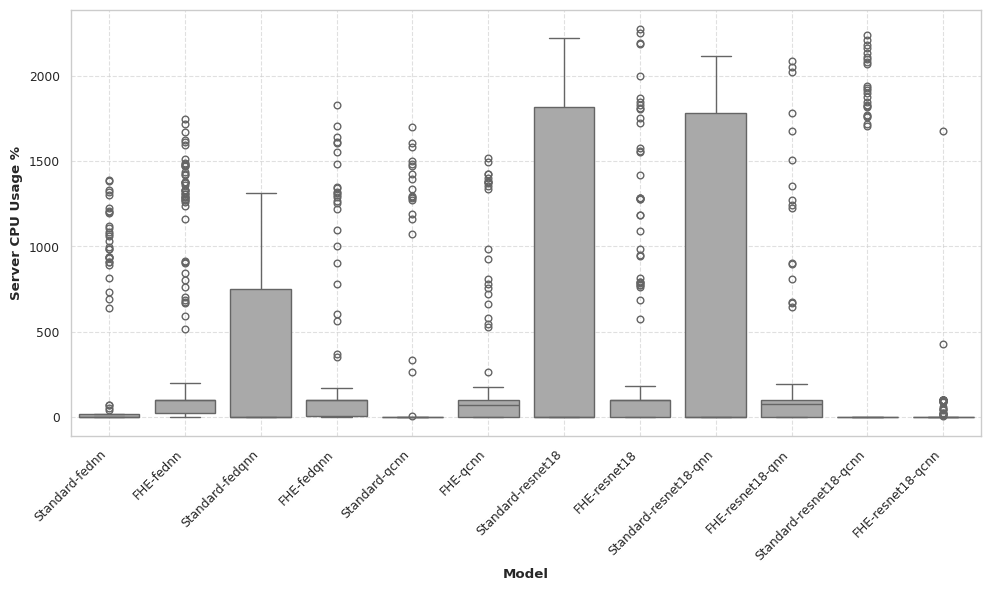

{
    "FHE-fednn": {
        "('Server CPU Usage %', 'count')": 470.0,
        "('Server CPU Usage %', 'mean')": 187.5325531915,
        "('Server CPU Usage %', 'std')": 367.5862417756,
        "('Server CPU Usage %', 'min')": 2.0,
        "('Server CPU Usage %', '25%')": 26.5,
        "('Server CPU Usage %', '50%')": 97.9,
        "('Server CPU Usage %', '75%')": 99.9,
        "('Server CPU Usage %', 'max')": 1746.2
    },
    "FHE-fedqnn": {
        "('Server CPU Usage %', 'count')": 373.0,
        "('Server CPU Usage %', 'mean')": 138.6155495979,
        "('Server CPU Usage %', 'std')": 299.5100192636,
        "('Server CPU Usage %', 'min')": 2.0,
        "('Server CPU Usage %', '25%')": 8.0,
        "('Server CPU Usage %', '50%')": 97.9,
        "('Server CPU Usage %', '75%')": 99.9,
        "('Server CPU Usage %', 'max')": 1826.0
    },
    "FHE-qcnn": {
        "('Server CPU Usage %', 'count')": 246.0,
        "('Server CPU Usage %', 'mean')": 139.118699187,
        "('Server CPU

In [21]:
server_cpu_usage = get_metric_by_model_type(
    runs, groups, "system_metric", "server_cpu_percentage"
)
metric_label = "Server CPU Usage %"
df = get_dataframe_from_metrics_data(server_cpu_usage, metric_label)
df = df[df[metric_label] > 0]
display_boxplot(df, metric_label)

stats = df.groupby("Model").describe()
stats = stats.to_json(orient="index")
parsed = loads(stats)
print(dumps(parsed, indent=4))

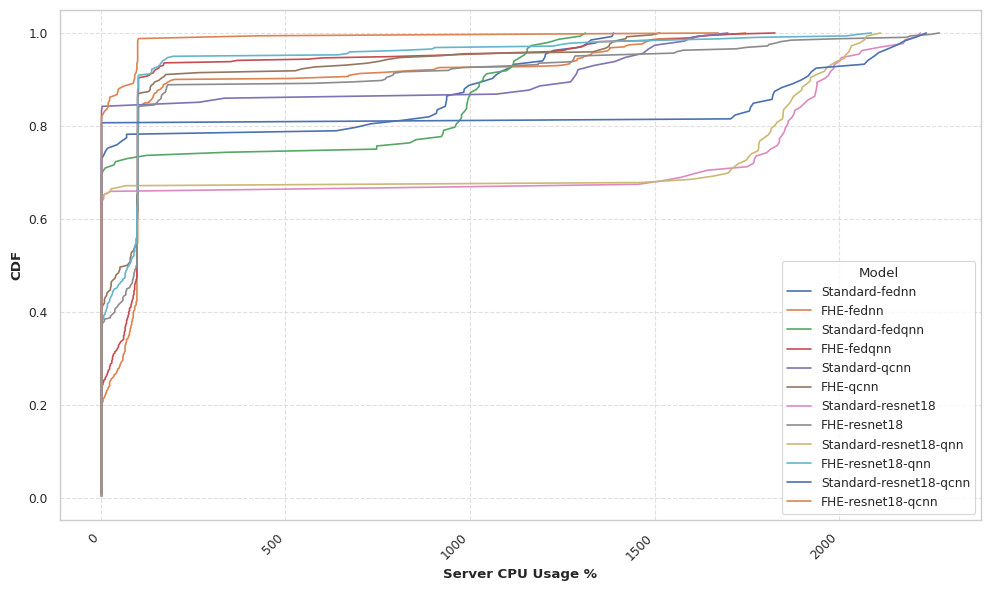

In [22]:
def display_cdf_plot(metrics_df: pd.DataFrame, metric_label: str):
    sns.set_theme(style="whitegrid", context="paper")

    fig, ax = plt.subplots(figsize=(10, 6))

    for model in metrics_df["Model"].unique():
        data = metrics_df[metrics_df["Model"] == model][metric_label]
        # Sort data for CDF calculation
        data_sorted = np.sort(data)
        cdf = np.arange(1, len(data_sorted) + 1) / len(data_sorted)
        ax.plot(data_sorted, cdf, label=model)

    plt.xticks(rotation=45, ha="right")
    plt.xlabel(metric_label, fontweight="bold")
    plt.ylabel("CDF", fontweight="bold")
    plt.grid(True, linestyle="--", alpha=0.6)

    ax.legend(title="Model")

    # Display the plot
    plt.tight_layout()
    plt.show()


# Example usage:
display_cdf_plot(df, metric_label)

# RAM Usage

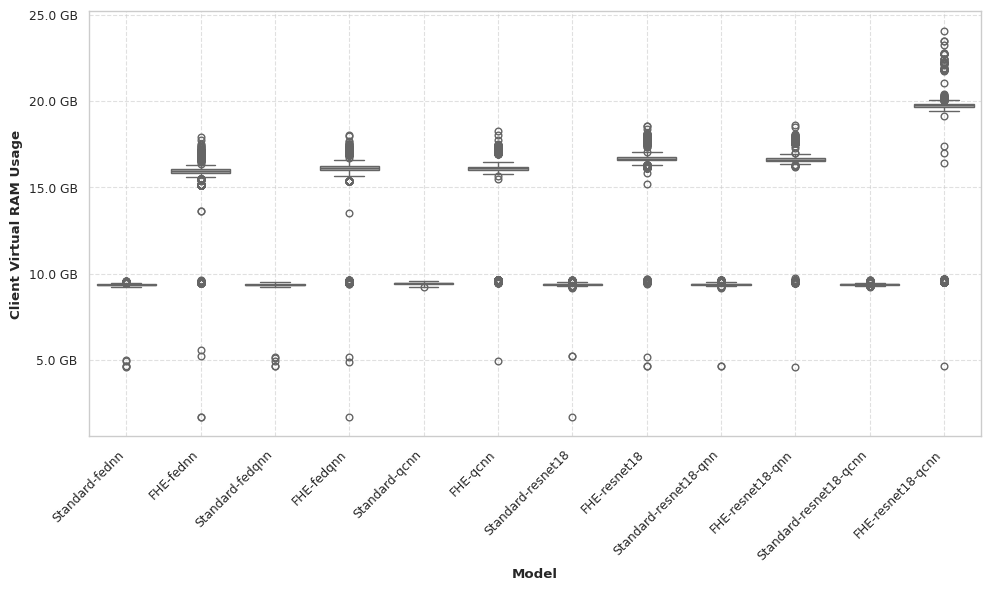

{
    "FHE-fednn": {
        "('Client Virtual RAM Usage', 'count')": 2446.0,
        "('Client Virtual RAM Usage', 'mean')": 15804.5269869174,
        "('Client Virtual RAM Usage', 'std')": 1364.7776605096,
        "('Client Virtual RAM Usage', 'min')": 1709.598,
        "('Client Virtual RAM Usage', '25%')": 15831.27725,
        "('Client Virtual RAM Usage', '50%')": 15942.3535,
        "('Client Virtual RAM Usage', '75%')": 16034.547,
        "('Client Virtual RAM Usage', 'max')": 17884.91
    },
    "FHE-fedqnn": {
        "('Client Virtual RAM Usage', 'count')": 2475.0,
        "('Client Virtual RAM Usage', 'mean')": 15911.3877361616,
        "('Client Virtual RAM Usage', 'std')": 1452.1439023015,
        "('Client Virtual RAM Usage', 'min')": 1707.203,
        "('Client Virtual RAM Usage', '25%')": 15974.055,
        "('Client Virtual RAM Usage', '50%')": 16108.543,
        "('Client Virtual RAM Usage', '75%')": 16236.777,
        "('Client Virtual RAM Usage', 'max')": 17999.008


In [23]:
def format_usage(usage_mb, _):
    if usage_mb < 1_000:
        return f"{int(usage_mb)} MB"
    else:
        gb = round(usage_mb / 1_000, 2)
        return f"{gb} GB"


client_vir_ram_usage = get_metric_by_model_type(
    runs, groups, "system_metric", "client_virtual_memory_mb"
)
metric_label = "Client Virtual RAM Usage"
df = get_dataframe_from_metrics_data(client_vir_ram_usage, metric_label)

display_boxplot(df, metric_label, format_usage)

stats = df.groupby("Model").describe()
stats = stats.to_json(orient="index")
parsed = loads(stats)
print(dumps(parsed, indent=4))

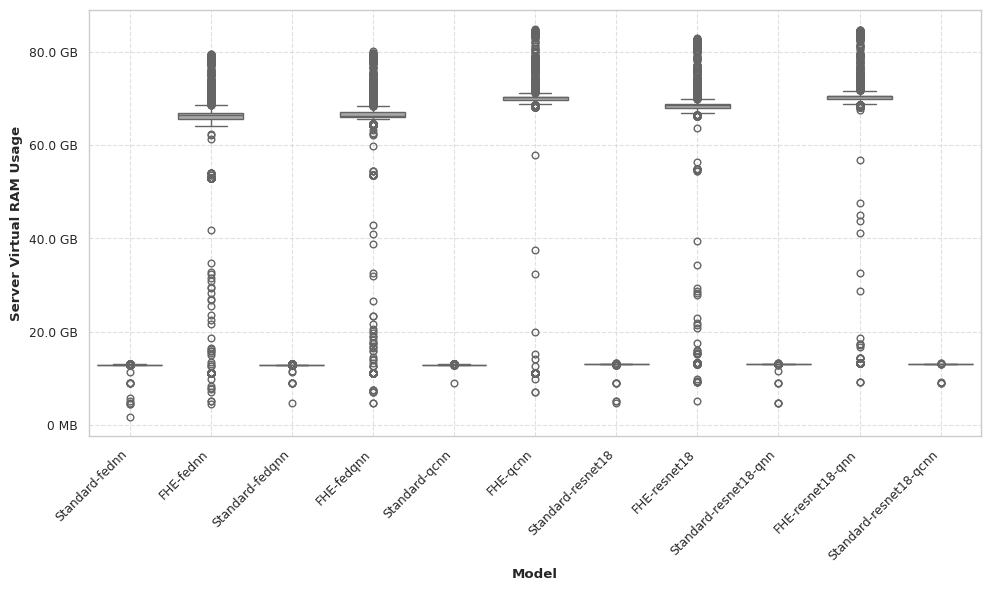

{
    "FHE-fednn": {
        "('Server Virtual RAM Usage', 'count')": 2435.0,
        "('Server Virtual RAM Usage', 'mean')": 64635.8883310062,
        "('Server Virtual RAM Usage', 'std')": 12441.9191567698,
        "('Server Virtual RAM Usage', 'min')": 4601.492,
        "('Server Virtual RAM Usage', '25%')": 65654.859,
        "('Server Virtual RAM Usage', '50%')": 66364.059,
        "('Server Virtual RAM Usage', '75%')": 66846.566,
        "('Server Virtual RAM Usage', 'max')": 79488.887
    },
    "FHE-fedqnn": {
        "('Server Virtual RAM Usage', 'count')": 2470.0,
        "('Server Virtual RAM Usage', 'mean')": 64185.0759008097,
        "('Server Virtual RAM Usage', 'std')": 13498.4006417418,
        "('Server Virtual RAM Usage', 'min')": 4812.301,
        "('Server Virtual RAM Usage', '25%')": 66054.543,
        "('Server Virtual RAM Usage', '50%')": 66312.688,
        "('Server Virtual RAM Usage', '75%')": 66964.25,
        "('Server Virtual RAM Usage', 'max')": 80133.664
 

In [24]:
server_vir_ram_usage = get_metric_by_model_type(
    runs, groups, "system_metric", "server_virtual_memory_mb"
)
metric_label = "Server Virtual RAM Usage"
df = get_dataframe_from_metrics_data(server_vir_ram_usage, metric_label)

display_boxplot(df[df["Model"] != "FHE-resnet18-qcnn"], metric_label, format_usage)

stats = df.groupby("Model").describe()
stats = stats.to_json(orient="index")
parsed = loads(stats)
print(dumps(parsed, indent=4))

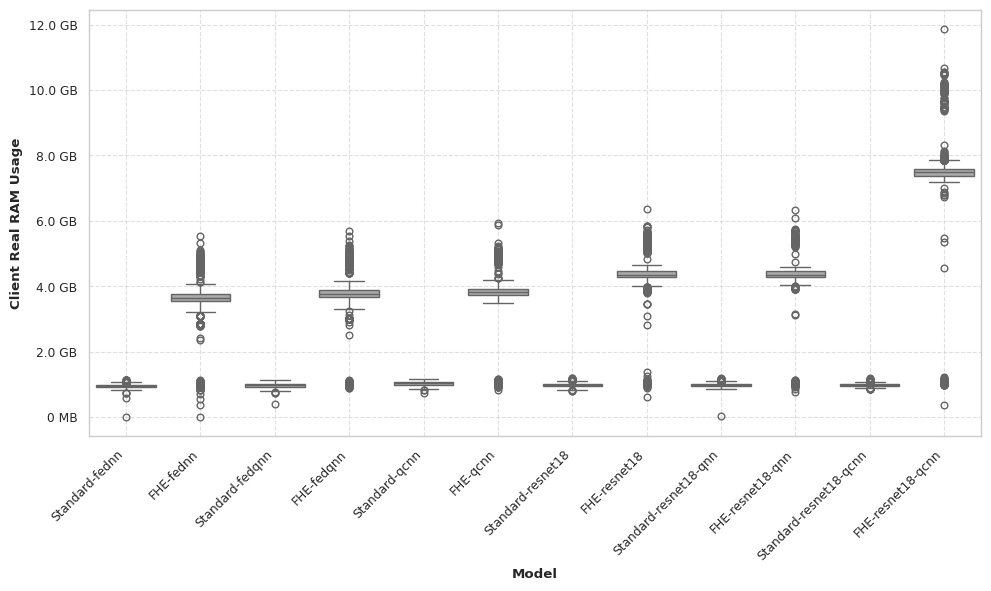

{
    "FHE-fednn": {
        "('Client Real RAM Usage', 'count')": 2438.0,
        "('Client Real RAM Usage', 'mean')": 3652.2681480722,
        "('Client Real RAM Usage', 'std')": 695.712730668,
        "('Client Real RAM Usage', 'min')": 15.0,
        "('Client Real RAM Usage', '25%')": 3545.465,
        "('Client Real RAM Usage', '50%')": 3651.672,
        "('Client Real RAM Usage', '75%')": 3774.20875,
        "('Client Real RAM Usage', 'max')": 5544.262
    },
    "FHE-fedqnn": {
        "('Client Real RAM Usage', 'count')": 2476.0,
        "('Client Real RAM Usage', 'mean')": 3745.7235981422,
        "('Client Real RAM Usage', 'std')": 700.7354505915,
        "('Client Real RAM Usage', 'min')": 879.43,
        "('Client Real RAM Usage', '25%')": 3663.80225,
        "('Client Real RAM Usage', '50%')": 3771.8925,
        "('Client Real RAM Usage', '75%')": 3899.1995,
        "('Client Real RAM Usage', 'max')": 5689.016
    },
    "FHE-qcnn": {
        "('Client Real RAM Usage', 'co

In [25]:
client_real_ram_usage = get_metric_by_model_type(
    runs, groups, "system_metric", "client_real_memory_mb"
)
metric_label = "Client Real RAM Usage"
df = get_dataframe_from_metrics_data(client_real_ram_usage, metric_label)

display_boxplot(df, metric_label, format_usage)

stats = df.groupby("Model").describe()
stats = stats.to_json(orient="index")
parsed = loads(stats)
print(dumps(parsed, indent=4))

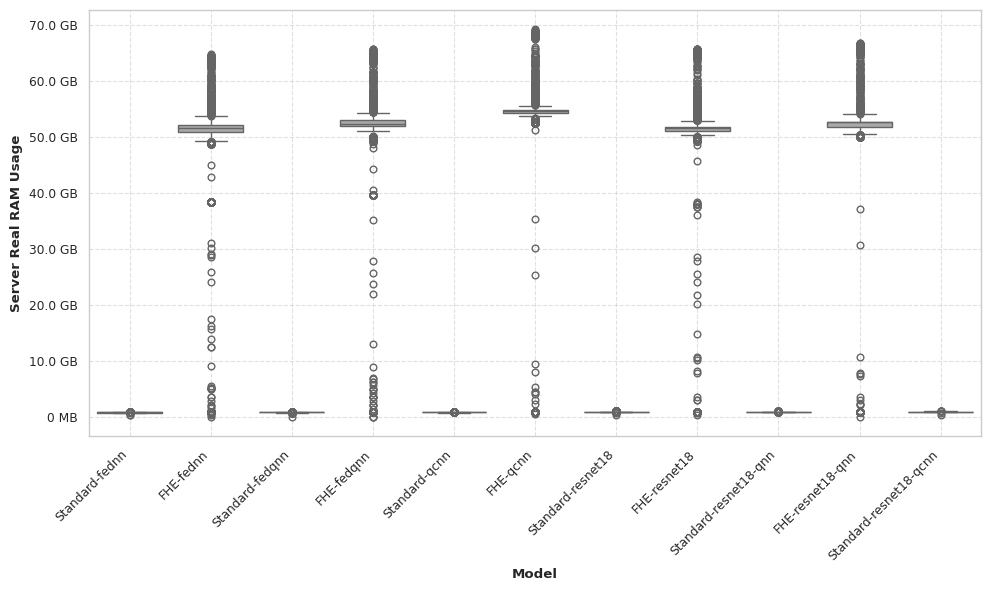

{
    "FHE-fednn": {
        "('Server Real RAM Usage', 'count')": 2438.0,
        "('Server Real RAM Usage', 'mean')": 49849.4044155045,
        "('Server Real RAM Usage', 'std')": 12091.3945510851,
        "('Server Real RAM Usage', 'min')": 69.0,
        "('Server Real RAM Usage', '25%')": 50938.652,
        "('Server Real RAM Usage', '50%')": 51647.566,
        "('Server Real RAM Usage', '75%')": 52076.047,
        "('Server Real RAM Usage', 'max')": 64808.48
    },
    "FHE-fedqnn": {
        "('Server Real RAM Usage', 'count')": 2470.0,
        "('Server Real RAM Usage', 'mean')": 50744.0119797571,
        "('Server Real RAM Usage', 'std')": 11939.3240501213,
        "('Server Real RAM Usage', 'min')": 33.5,
        "('Server Real RAM Usage', '25%')": 52005.84,
        "('Server Real RAM Usage', '50%')": 52323.592,
        "('Server Real RAM Usage', '75%')": 52961.492,
        "('Server Real RAM Usage', 'max')": 65759.551
    },
    "FHE-qcnn": {
        "('Server Real RAM Usage'

In [26]:
server_real_ram_usage = get_metric_by_model_type(
    runs, groups, "system_metric", "server_real_memory_mb"
)
metric_label = "Server Real RAM Usage"
df = get_dataframe_from_metrics_data(server_real_ram_usage, metric_label)
display_boxplot(df[df["Model"] != "FHE-resnet18-qcnn"], metric_label, format_usage)

stats = df.groupby("Model").describe()
stats = stats.to_json(orient="index")
parsed = loads(stats)
print(dumps(parsed, indent=4))

# FHE

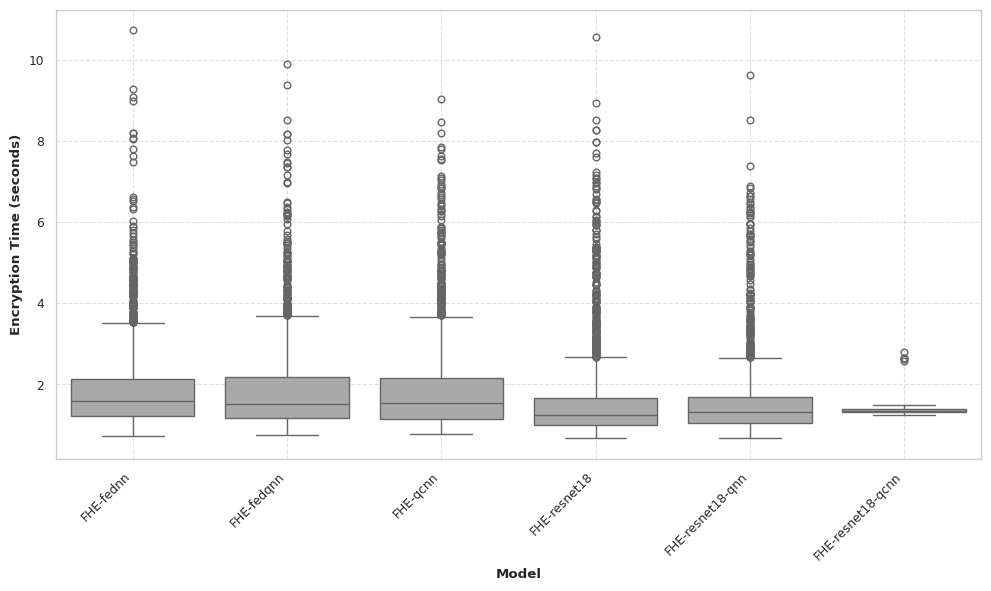

{
    "FHE-fednn": {
        "('Encryption Time (seconds)', 'count')": 2000.0,
        "('Encryption Time (seconds)', 'mean')": 1.8732074938,
        "('Encryption Time (seconds)', 'std')": 1.0531322246,
        "('Encryption Time (seconds)', 'min')": 0.7165923119,
        "('Encryption Time (seconds)', '25%')": 1.213804245,
        "('Encryption Time (seconds)', '50%')": 1.5932282209,
        "('Encryption Time (seconds)', '75%')": 2.1421750188,
        "('Encryption Time (seconds)', 'max')": 10.7331938744
    },
    "FHE-fedqnn": {
        "('Encryption Time (seconds)', 'count')": 2000.0,
        "('Encryption Time (seconds)', 'mean')": 1.8637973101,
        "('Encryption Time (seconds)', 'std')": 1.0875810257,
        "('Encryption Time (seconds)', 'min')": 0.7509920597,
        "('Encryption Time (seconds)', '25%')": 1.1699082851,
        "('Encryption Time (seconds)', '50%')": 1.52336061,
        "('Encryption Time (seconds)', '75%')": 2.1787727475,
        "('Encryption Time (sec

In [27]:
client_encryption_time = get_metric_by_model_type(
    runs, groups, "client_metric", "encryption_time"
)
metric_label = "Encryption Time (seconds)"
df = get_dataframe_from_metrics_data(client_encryption_time, metric_label)

display_boxplot(df, metric_label)

stats = df.groupby("Model").describe()
stats = stats.to_json(orient="index")
parsed = loads(stats)
print(dumps(parsed, indent=4))

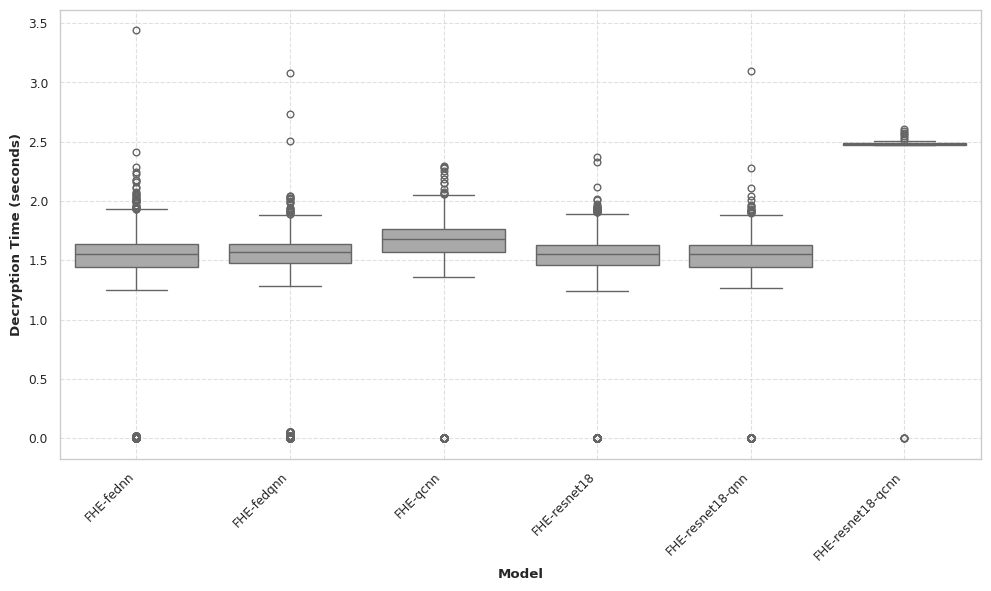

{
    "FHE-fednn": {
        "('Decryption Time (seconds)', 'count')": 2100.0,
        "('Decryption Time (seconds)', 'mean')": 1.4865961895,
        "('Decryption Time (seconds)', 'std')": 0.3636276542,
        "('Decryption Time (seconds)', 'min')": 0.000890255,
        "('Decryption Time (seconds)', '25%')": 1.4429298639,
        "('Decryption Time (seconds)', '50%')": 1.5523122549,
        "('Decryption Time (seconds)', '75%')": 1.6385290623,
        "('Decryption Time (seconds)', 'max')": 3.4397621155
    },
    "FHE-fedqnn": {
        "('Decryption Time (seconds)', 'count')": 2100.0,
        "('Decryption Time (seconds)', 'mean')": 1.4974709401,
        "('Decryption Time (seconds)', 'std')": 0.3550589327,
        "('Decryption Time (seconds)', 'min')": 0.0008351803,
        "('Decryption Time (seconds)', '25%')": 1.4777171612,
        "('Decryption Time (seconds)', '50%')": 1.5685616732,
        "('Decryption Time (seconds)', '75%')": 1.640781343,
        "('Decryption Time (sec

In [28]:
client_decryption_time = get_metric_by_model_type(
    runs, groups, "client_metric", "decryption_time"
)
metric_label = "Decryption Time (seconds)"
df = get_dataframe_from_metrics_data(client_decryption_time, metric_label)

display_boxplot(df, metric_label)

stats = df.groupby("Model").describe()
stats = stats.to_json(orient="index")
parsed = loads(stats)
print(dumps(parsed, indent=4))

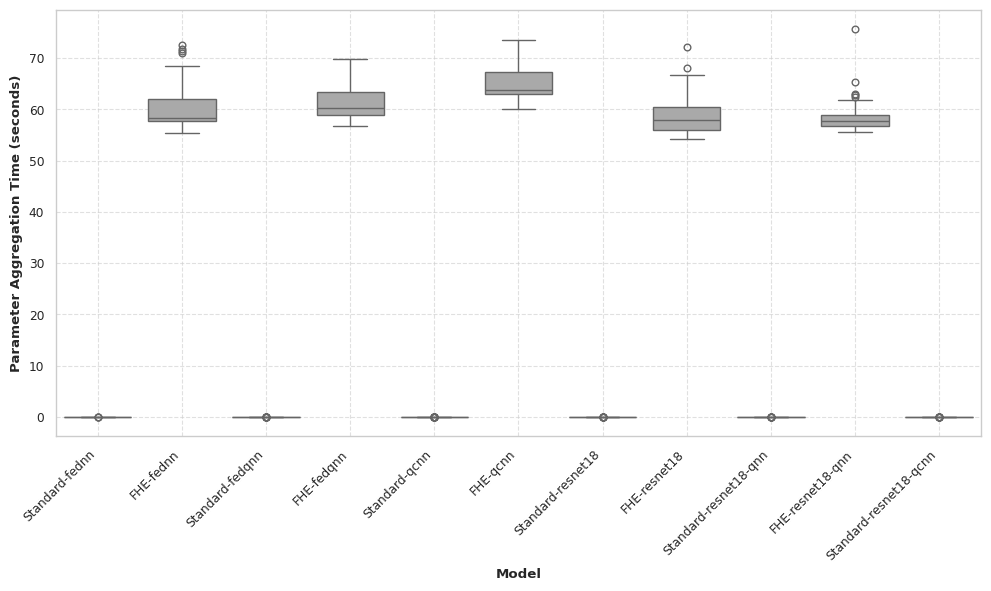

{
    "FHE-fednn": {
        "('Parameter Aggregation Time (seconds)', 'count')": 100.0,
        "('Parameter Aggregation Time (seconds)', 'mean')": 59.790676353,
        "('Parameter Aggregation Time (seconds)', 'std')": 3.6866565677,
        "('Parameter Aggregation Time (seconds)', 'min')": 55.427822113,
        "('Parameter Aggregation Time (seconds)', '25%')": 57.7014110088,
        "('Parameter Aggregation Time (seconds)', '50%')": 58.3568747044,
        "('Parameter Aggregation Time (seconds)', '75%')": 62.0786504149,
        "('Parameter Aggregation Time (seconds)', 'max')": 72.59516716
    },
    "FHE-fedqnn": {
        "('Parameter Aggregation Time (seconds)', 'count')": 100.0,
        "('Parameter Aggregation Time (seconds)', 'mean')": 61.1681371975,
        "('Parameter Aggregation Time (seconds)', 'std')": 3.0057458621,
        "('Parameter Aggregation Time (seconds)', 'min')": 56.8269331455,
        "('Parameter Aggregation Time (seconds)', '25%')": 58.9807604551,
       

In [29]:
server_aggregation_time = get_metric_by_model_type(
    runs, groups, "server_metric", "parameter_aggregation_time"
)
metric_label = "Parameter Aggregation Time (seconds)"
df = get_dataframe_from_metrics_data(server_aggregation_time, metric_label)

display_boxplot(df[df["Model"] != "FHE-resnet18-qcnn"], metric_label)

stats = df.groupby("Model").describe()
stats = stats.to_json(orient="index")
parsed = loads(stats)
print(dumps(parsed, indent=4))

# Communication Overhead

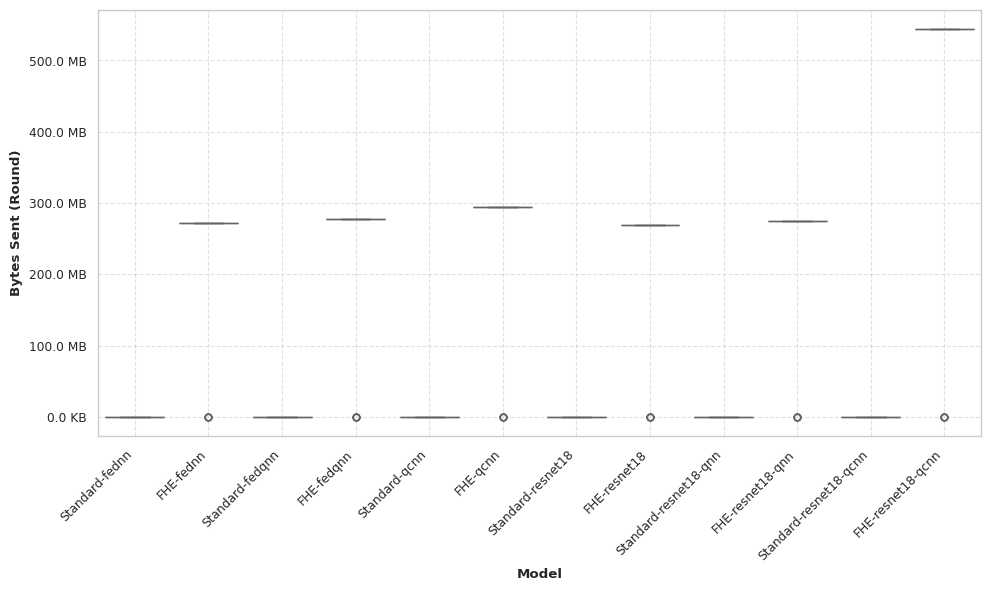

{
    "FHE-fednn": {
        "('Bytes Sent (Round)', 'count')": 100.0,
        "('Bytes Sent (Round)', 'mean')": 257764098.1,
        "('Bytes Sent (Round)', 'std')": 59430876.19839907,
        "('Bytes Sent (Round)', 'min')": 9435.0,
        "('Bytes Sent (Round)', '25%')": 271330133.0,
        "('Bytes Sent (Round)', '50%')": 271330133.0,
        "('Bytes Sent (Round)', '75%')": 271330133.0,
        "('Bytes Sent (Round)', 'max')": 271330133.0
    },
    "FHE-fedqnn": {
        "('Bytes Sent (Round)', 'count')": 100.0,
        "('Bytes Sent (Round)', 'mean')": 263248506.95,
        "('Bytes Sent (Round)', 'std')": 60695293.31232246,
        "('Bytes Sent (Round)', 'min')": 10004.0,
        "('Bytes Sent (Round)', '25%')": 277103165.0,
        "('Bytes Sent (Round)', '50%')": 277103165.0,
        "('Bytes Sent (Round)', '75%')": 277103165.0,
        "('Bytes Sent (Round)', 'max')": 277103165.0
    },
    "FHE-qcnn": {
        "('Bytes Sent (Round)', 'count')": 100.0,
        "('Bytes 

In [30]:
def format_bytes(bytes, _):
    if bytes < 1_000_000:
        value = round(int(bytes) * 0.001, 2)
        return f"{value} KB"
    if bytes < 1_000_000_000:
        value = round(int(bytes) * 0.000001, 2)
        return f"{value} MB"
    else:
        value = round(int(bytes) * 1e-9, 2)
        return f"{value} GB"


server_bytes_sent = get_metric_by_model_type(
    runs, groups, "server_metric", "Bytes Sent (Round)"
)
metric_label = "Bytes Sent (Round)"
df = get_dataframe_from_metrics_data(server_bytes_sent, metric_label)

display_boxplot(df, metric_label, format_bytes)

stats = df.groupby("Model").describe()
stats = stats.to_json(orient="index")
parsed = loads(stats)
print(dumps(parsed, indent=4))

In [31]:
stats = df.groupby("Model").describe()[("Bytes Sent (Round)", "max")].reset_index()
stats["MB Sent (Round)"] = stats["Bytes Sent (Round)"] / (1024**2)
stats["Model"] = pd.Categorical(stats["Model"], categories=KEY_ORDER, ordered=True)
stats = stats.sort_values("Model").reset_index(drop=True)
stats

,Model,Bytes Sent (Round),MB Sent (Round)
,,max,
0,Standard-fednn,9435.0,0.008998
1,FHE-fednn,271330133.0,258.760579
2,Standard-fedqnn,10004.0,0.009541
3,FHE-fedqnn,277103165.0,264.266171
4,Standard-qcnn,10520.0,0.010033
5,FHE-qcnn,294028480.0,280.407410
6,Standard-resnet18,8573.0,0.008176
7,FHE-resnet18,269230755.0,256.758456
8,Standard-resnet18-qnn,9142.0,0.008718


In [32]:
stats = stats.to_json(orient="index")
parsed = loads(stats)
print(dumps(parsed, indent=4))

{
    "0": {
        "('Model', '')": "Standard-fednn",
        "('Bytes Sent (Round)', 'max')": 9435.0,
        "('MB Sent (Round)', '')": 0.0089979172
    },
    "1": {
        "('Model', '')": "FHE-fednn",
        "('Bytes Sent (Round)', 'max')": 271330133.0,
        "('MB Sent (Round)', '')": 258.7605791092
    },
    "2": {
        "('Model', '')": "Standard-fedqnn",
        "('Bytes Sent (Round)', 'max')": 10004.0,
        "('MB Sent (Round)', '')": 0.0095405579
    },
    "3": {
        "('Model', '')": "FHE-fedqnn",
        "('Bytes Sent (Round)', 'max')": 277103165.0,
        "('MB Sent (Round)', '')": 264.2661714554
    },
    "4": {
        "('Model', '')": "Standard-qcnn",
        "('Bytes Sent (Round)', 'max')": 10520.0,
        "('MB Sent (Round)', '')": 0.0100326538
    },
    "5": {
        "('Model', '')": "FHE-qcnn",
        "('Bytes Sent (Round)', 'max')": 294028480.0,
        "('MB Sent (Round)', '')": 280.407409668
    },
    "6": {
        "('Model', '')": "Standa

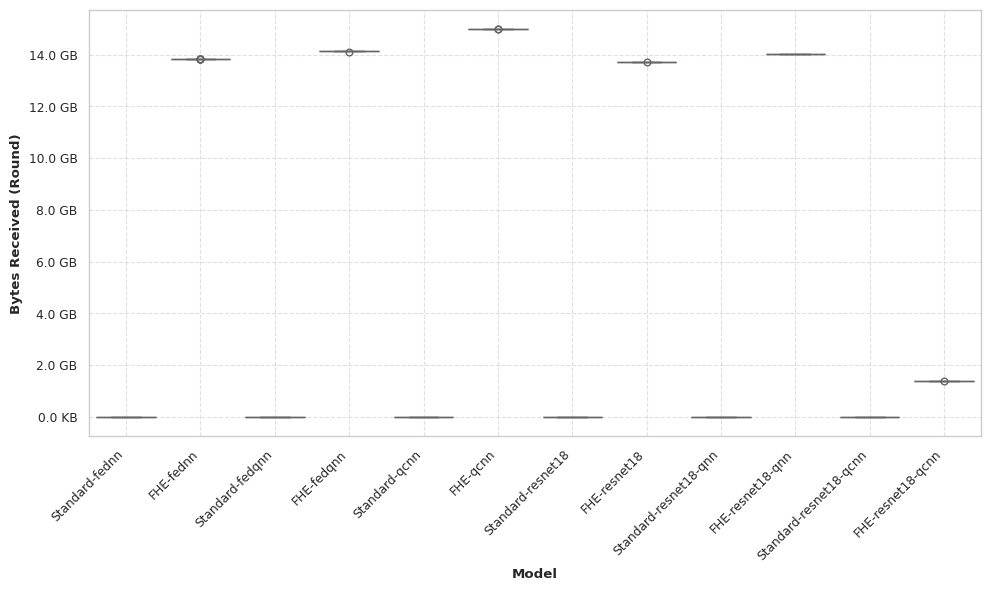

{
    "FHE-fednn": {
        "('Bytes Received (Round)', 'count')": 100.0,
        "('Bytes Received (Round)', 'mean')": 13825693600.09,
        "('Bytes Received (Round)', 'std')": 36938.0634330461,
        "('Bytes Received (Round)', 'min')": 13825584283.0,
        "('Bytes Received (Round)', '25%')": 13825674706.0,
        "('Bytes Received (Round)', '50%')": 13825692157.5,
        "('Bytes Received (Round)', '75%')": 13825713580.0,
        "('Bytes Received (Round)', 'max')": 13825775941.0
    },
    "FHE-fedqnn": {
        "('Bytes Received (Round)', 'count')": 100.0,
        "('Bytes Received (Round)', 'mean')": 14119859904.01,
        "('Bytes Received (Round)', 'std')": 38749.2133593651,
        "('Bytes Received (Round)', 'min')": 14119724356.0,
        "('Bytes Received (Round)', '25%')": 14119836086.25,
        "('Bytes Received (Round)', '50%')": 14119858948.0,
        "('Bytes Received (Round)', '75%')": 14119887373.25,
        "('Bytes Received (Round)', 'max')": 14119946

In [33]:
server_bytes_received = get_metric_by_model_type(
    runs, groups, "server_metric", "Bytes Received (Round)"
)
metric_label = "Bytes Received (Round)"
df = get_dataframe_from_metrics_data(server_bytes_received, metric_label)

display_boxplot(df, metric_label, format_bytes)

stats = df.groupby("Model").describe()
stats = stats.to_json(orient="index")
parsed = loads(stats)
print(dumps(parsed, indent=4))

In [34]:
stats = df.groupby("Model").describe()[("Bytes Received (Round)", "max")].reset_index()
stats["MB Received (Round)"] = stats["Bytes Received (Round)"] / (1024**2)
stats["Model"] = pd.Categorical(stats["Model"], categories=KEY_ORDER, ordered=True)
stats = stats.sort_values("Model").reset_index(drop=True)
stats

,Model,Bytes Received (Round),MB Received (Round)
,,max,
0,Standard-fednn,1.887000e+05,0.179958
1,FHE-fednn,1.382578e+10,13185.287419
2,Standard-fedqnn,2.000800e+05,0.190811
3,FHE-fedqnn,1.411995e+10,13465.829853
4,Standard-qcnn,2.104000e+05,0.200653
5,FHE-qcnn,1.498238e+10,14288.308361
6,Standard-resnet18,1.714600e+05,0.163517
7,FHE-resnet18,1.371885e+10,13083.314004
8,Standard-resnet18-qnn,1.828400e+05,0.174370


In [35]:
stats = stats.to_json(orient="index")
parsed = loads(stats)
print(dumps(parsed, indent=4))

{
    "0": {
        "('Model', '')": "Standard-fednn",
        "('Bytes Received (Round)', 'max')": 188700.0,
        "('MB Received (Round)', '')": 0.1799583435
    },
    "1": {
        "('Model', '')": "FHE-fednn",
        "('Bytes Received (Round)', 'max')": 13825775941.0,
        "('MB Received (Round)', '')": 13185.2874193192
    },
    "2": {
        "('Model', '')": "Standard-fedqnn",
        "('Bytes Received (Round)', 'max')": 200080.0,
        "('MB Received (Round)', '')": 0.1908111572
    },
    "3": {
        "('Model', '')": "FHE-fedqnn",
        "('Bytes Received (Round)', 'max')": 14119946004.0,
        "('MB Received (Round)', '')": 13465.8298530579
    },
    "4": {
        "('Model', '')": "Standard-qcnn",
        "('Bytes Received (Round)', 'max')": 210400.0,
        "('MB Received (Round)', '')": 0.2006530762
    },
    "5": {
        "('Model', '')": "FHE-qcnn",
        "('Bytes Received (Round)', 'max')": 14982377228.0,
        "('MB Received (Round)', '')": 14

In [36]:
server_total_bytes_sent = get_metric_by_model_type(
    runs, groups, "server_metric", "Total Bytes Sent"
)
metric_label = "Total Bytes Sent"
df = get_dataframe_from_metrics_data(server_total_bytes_sent, metric_label)

stats = df.groupby("Model").describe()[("Total Bytes Sent", "max")].reset_index()
stats["MB Total Bytes Sent"] = stats["Total Bytes Sent"] / (1024**2)
stats["Model"] = pd.Categorical(stats["Model"], categories=KEY_ORDER, ordered=True)
stats = stats.sort_values("Model").reset_index(drop=True)
stats = stats.to_json(orient="index")
parsed = loads(stats)
print(dumps(parsed, indent=4))

{
    "0": {
        "('Model', '')": "Standard-fednn",
        "('Total Bytes Sent', 'max')": 188700.0,
        "('MB Total Bytes Sent', '')": 0.1799583435
    },
    "1": {
        "('Model', '')": "FHE-fednn",
        "('Total Bytes Sent', 'max')": 5155281962.0,
        "('MB Total Bytes Sent', '')": 4916.4600009918
    },
    "2": {
        "('Model', '')": "Standard-fedqnn",
        "('Total Bytes Sent', 'max')": 200080.0,
        "('MB Total Bytes Sent', '')": 0.1908111572
    },
    "3": {
        "('Model', '')": "FHE-fedqnn",
        "('Total Bytes Sent', 'max')": 5264970139.0,
        "('MB Total Bytes Sent', '')": 5021.0667982101
    },
    "4": {
        "('Model', '')": "Standard-qcnn",
        "('Total Bytes Sent', 'max')": 210400.0,
        "('MB Total Bytes Sent', '')": 0.2006530762
    },
    "5": {
        "('Model', '')": "FHE-qcnn",
        "('Total Bytes Sent', 'max')": 5586551640.0,
        "('MB Total Bytes Sent', '')": 5327.7508163452
    },
    "6": {
        "

In [37]:
server_total_bytes_received = get_metric_by_model_type(
    runs, groups, "server_metric", "Total Bytes Received"
)
metric_label = "Total Bytes Received"
df = get_dataframe_from_metrics_data(server_total_bytes_received, metric_label)

stats = df.groupby("Model").describe()[("Total Bytes Received", "max")].reset_index()
stats["MB Total Bytes Received"] = stats["Total Bytes Received"] / (1024**2)
stats["Model"] = pd.Categorical(stats["Model"], categories=KEY_ORDER, ordered=True)
stats = stats.sort_values("Model").reset_index(drop=True)
stats = stats.to_json(orient="index")
parsed = loads(stats)
print(dumps(parsed, indent=4))

{
    "0": {
        "('Model', '')": "Standard-fednn",
        "('Total Bytes Received', 'max')": 3774000.0,
        "('MB Total Bytes Received', '')": 3.5991668701
    },
    "1": {
        "('Model', '')": "FHE-fednn",
        "('Total Bytes Received', 'max')": 276514110474.0,
        "('MB Total Bytes Received', '')": 263704.4052829742
    },
    "2": {
        "('Model', '')": "Standard-fedqnn",
        "('Total Bytes Received', 'max')": 4001600.0,
        "('MB Total Bytes Received', '')": 3.8162231445
    },
    "3": {
        "('Model', '')": "FHE-fedqnn",
        "('Total Bytes Received', 'max')": 282397346378.0,
        "('MB Total Bytes Received', '')": 269315.0962619781
    },
    "4": {
        "('Model', '')": "Standard-qcnn",
        "('Total Bytes Received', 'max')": 4208000.0,
        "('MB Total Bytes Received', '')": 4.0130615234
    },
    "5": {
        "('Model', '')": "FHE-qcnn",
        "('Total Bytes Received', 'max')": 299645853391.0,
        "('MB Total Bytes

# Classification Metrics

In [38]:
def get_classification_metrics(
    runs: List[wandb.apis.public.runs.Run],
    groups: List[str],
    metric: str,
) -> dict:
    metric_type = "server_metric"
    metrics = {}
    for group in groups:
        try:
            if (metric in ["metrics_central.accuracy", "loss_central"]) and (
                "FHE" in group
            ):
                continue
            grouped_runs = [
                run for run in runs if run.config.get("group", None) == group
            ]
            history = None
            for run in grouped_runs:
                if (
                    metric_type == "server_metric"
                    and run.config.get("participant", "") == "server"
                ):
                    history = run.history()
                else:
                    continue

                # Store only last value
                metric_value = [val for val in history[metric] if not np.isnan(val)][-1]

                model = "-".join(group.split("-")[:-1])
                if model in metrics.keys():
                    metrics[model].append(metric_value)
                else:
                    metrics[model] = [metric_value]
        except KeyError:
            print(f"Somehow parameter was not found for group {group}.")
            continue

    metrics = {k: metrics[k] for k in KEY_ORDER if k in metrics.keys()}
    return metrics

In [39]:
stats = {}
for metric in [
    "metrics_central.accuracy",
    "loss_central",
    "metrics_agg.accuracy",
    "metrics_agg.recalls",
    "metrics_agg.f1s",
    "metrics_agg.precisions",
    "loss_agg",
]:
    metric_values = get_classification_metrics(runs, groups, metric)
    stats[metric] = metric_values

In [40]:
stats

{'metrics_central.accuracy': {'Standard-fednn': [63.48839496459481,
   65.4676435877262,
   63.717053501180175,
   64.32680959874115,
   64.70790715971675],
  'Standard-fedqnn': [63.64083398898506,
   60.973151062155786,
   61.73534618410701,
   65.39388276947285,
   63.1072974036192],
  'Standard-qcnn': [61.73534618410701,
   66.00118017309204,
   66.6133949645948,
   62.26888276947285,
   63.18351691581432],
  'Standard-resnet18': [52.22020062942565,
   51.31048387096775,
   53.61673878835563,
   46.58733280881196,
   59.95033438237608],
  'Standard-resnet18-qnn': [50.96134933123525,
   44.089299763965386,
   52.82012195121951,
   22.25609756097561,
   54.543666404405975],
  'Standard-resnet18-qcnn': [39.12027930763178,
   36.371459480723836,
   40.093922108575924,
   54.08634933123525,
   16.234756097560975]},
 'loss_central': {'Standard-fednn': [0.8622442955469213,
   0.8259996163045488,
   0.8491217986476131,
   0.8420959220426839,
   0.8374239451638082],
  'Standard-fedqnn': [0.8

In [41]:
rows = []

for metric, models_dict in stats.items():
    for model, values_list in models_dict.items():
        for value in values_list:
            rows.append({"model": model, "metric": metric, "value": value})

df = pd.DataFrame(rows)

stats_groupby = df.groupby(["model", "metric"]).describe()
stats_groupby = stats_groupby.to_json(orient="index")
parsed = loads(stats_groupby)
print(dumps(parsed, indent=4))

{
    "('FHE-fednn', 'loss_agg')": {
        "('value', 'count')": 5.0,
        "('value', 'mean')": 0.7063991982,
        "('value', 'std')": 0.0356170266,
        "('value', 'min')": 0.6636831149,
        "('value', '25%')": 0.6715664417,
        "('value', '50%')": 0.727742359,
        "('value', '75%')": 0.7337159187,
        "('value', 'max')": 0.7352881566
    },
    "('FHE-fednn', 'metrics_agg.accuracy')": {
        "('value', 'count')": 5.0,
        "('value', 'mean')": 72.1625615764,
        "('value', 'std')": 1.6038743352,
        "('value', 'min')": 70.7573891626,
        "('value', '25%')": 70.9544334975,
        "('value', '50%')": 71.4839901478,
        "('value', '75%')": 73.1096059113,
        "('value', 'max')": 74.5073891626
    },
    "('FHE-fednn', 'metrics_agg.f1s')": {
        "('value', 'count')": 5.0,
        "('value', 'mean')": 0.7216256158,
        "('value', 'std')": 0.0160387434,
        "('value', 'min')": 0.7075738916,
        "('value', '25%')": 0.70954